In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import glob
import datetime
from joblib import Parallel, delayed
from neuraltda import simpComp as sc
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

homedir = os.path.expanduser('~')
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = os.path.join(homedir, 'DailyLog/'+daystr+'/')
print(figsavepth)
plt.style.use(os.path.join(homedir, 'code/NeuralTDA/gentnerlab.mplstyle'))

/home/brad/DailyLog/20190411/


In [2]:
def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_JS_div_mtx(lapspectra, Mspectra, beta):
    N = len(lapspectra)
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    #print('Computing JS Divergences with beta {}...'.format(beta))
    jsmat = np.zeros((N, N))
    jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, lapspectra[i], lapspectra[j], Mspectra[(i,j)], beta) for (i, j) in pairs)
    for d in jsdat:
        jsmat[d[0], d[1]] = d[2]
    
    return jsmat

def compute_within_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within)

def get_lapfile_params(lapfile):
    lap_filename = os.path.splitext(os.path.split(lapfile)[-1])[0]
    params = lap_filename.split('Lapsectra_')[-1].split('-')
    fam = params[-1]
    shuf = params[-2]
    ntrials = params[-3]
    bird = params[-4]
    return {'bird': bird, 'ntrials': ntrials, 'shuf': shuf, 'fam': fam}

def compute_withins_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within1, within2)

In [3]:
betas = np.logspace(-1, 2)
nstim = 4
ntrials=20

lap_path = os.path.join(homedir, 'laplacians/Lapspectra*.pkl')
m_path = os.path.join(homedir, 'laplacians/Mspectra*.pkl')


lap_files = glob.glob(lap_path)
m_files = glob.glob(m_path)

file_pairs = []
for lap_file in lap_files:
    lap_filename = os.path.split(lap_file)[-1]
    params = lap_filename.split('Lapspectra')[-1]
    m_files = glob.glob(os.path.join(homedir, 'laplacians/'+'Mspectra'+params))
    if m_files:
        file_pairs.append((lap_file, m_files[0]))

file_pairs = sorted(file_pairs)
print(file_pairs)

[('/home/brad/laplacians/Lapspectra_B1056-20-original-familiar.pkl', '/home/brad/laplacians/Mspectra_B1056-20-original-familiar.pkl'), ('/home/brad/laplacians/Lapspectra_B1056-20-original-unfamiliar.pkl', '/home/brad/laplacians/Mspectra_B1056-20-original-unfamiliar.pkl'), ('/home/brad/laplacians/Lapspectra_B1056-20-shuffled-familiar.pkl', '/home/brad/laplacians/Mspectra_B1056-20-shuffled-familiar.pkl'), ('/home/brad/laplacians/Lapspectra_B1056-20-shuffled-unfamiliar.pkl', '/home/brad/laplacians/Mspectra_B1056-20-shuffled-unfamiliar.pkl'), ('/home/brad/laplacians/Lapspectra_B1083-20-original-familiar.pkl', '/home/brad/laplacians/Mspectra_B1083-20-original-familiar.pkl'), ('/home/brad/laplacians/Lapspectra_B1083-20-original-unfamiliar.pkl', '/home/brad/laplacians/Mspectra_B1083-20-original-unfamiliar.pkl'), ('/home/brad/laplacians/Lapspectra_B1083-20-shuffled-familiar.pkl', '/home/brad/laplacians/Mspectra_B1083-20-shuffled-familiar.pkl'), ('/home/brad/laplacians/Lapspectra_B1083-20-shuff

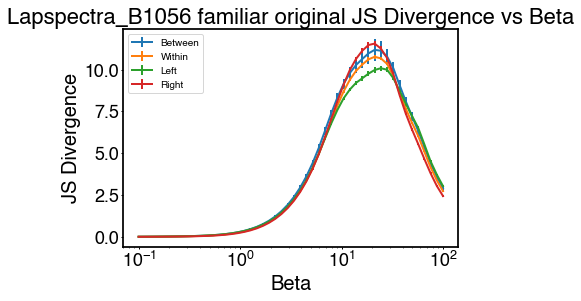

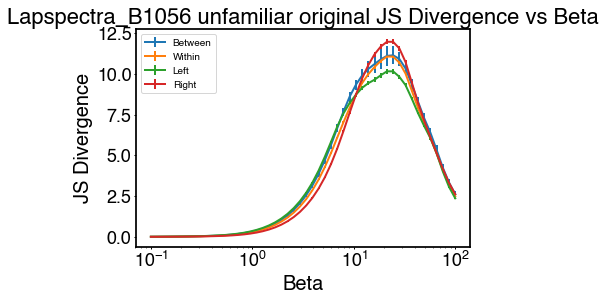

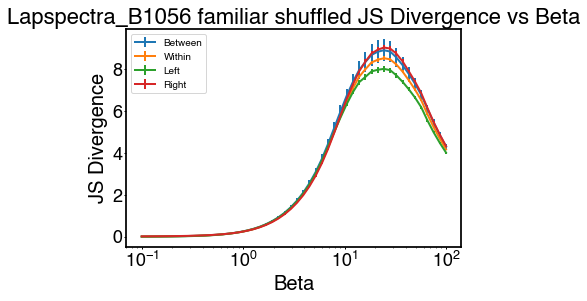

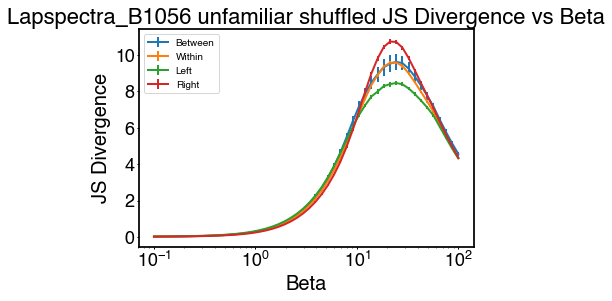

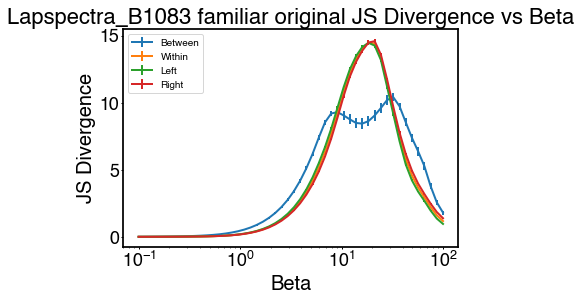

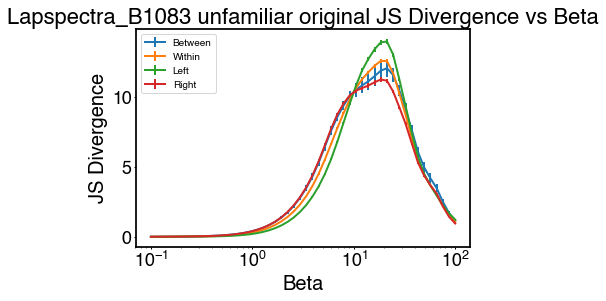

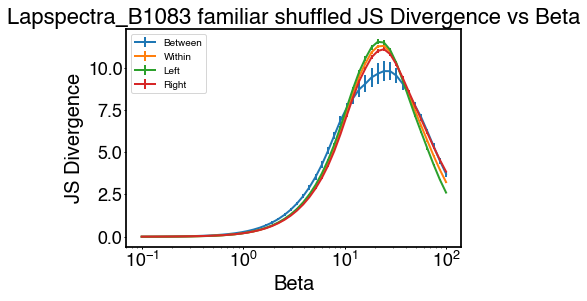

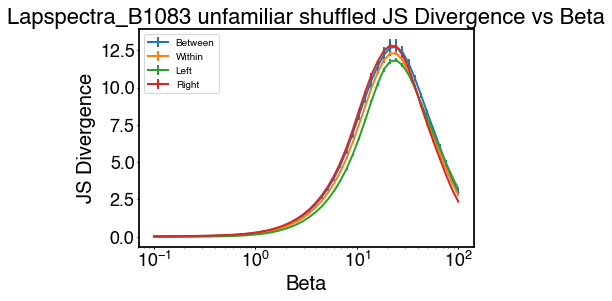

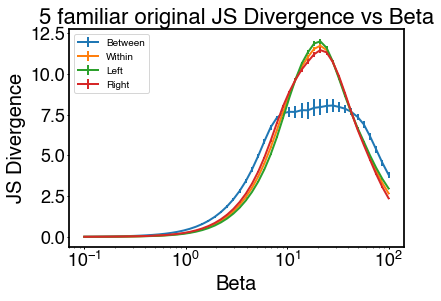

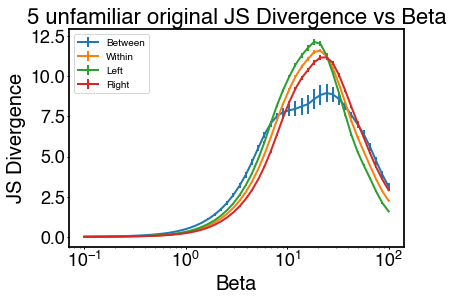

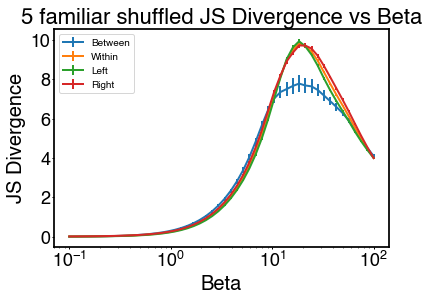

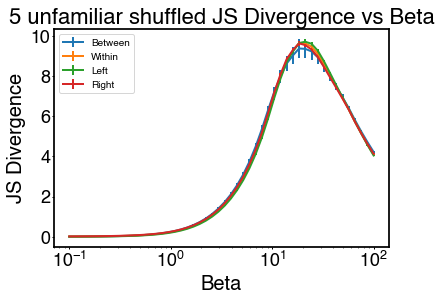

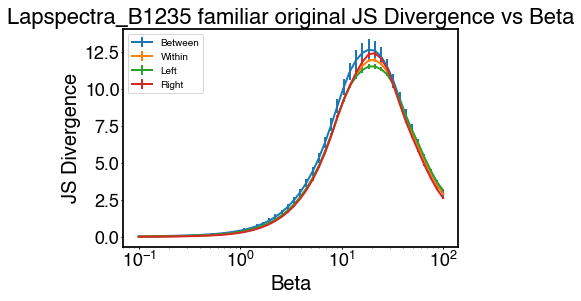

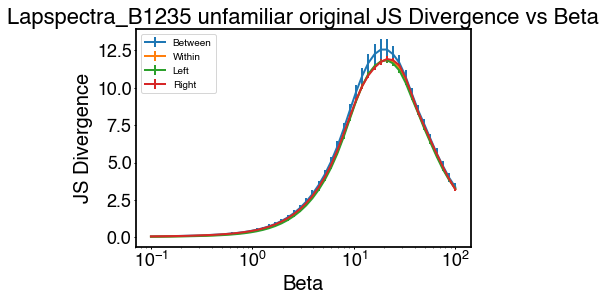

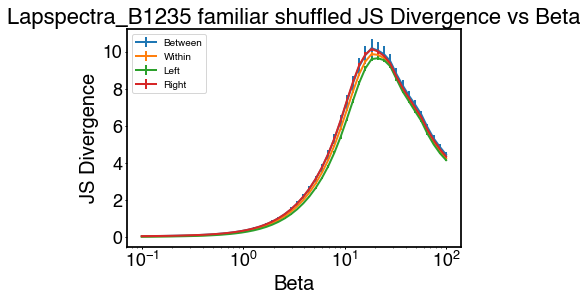

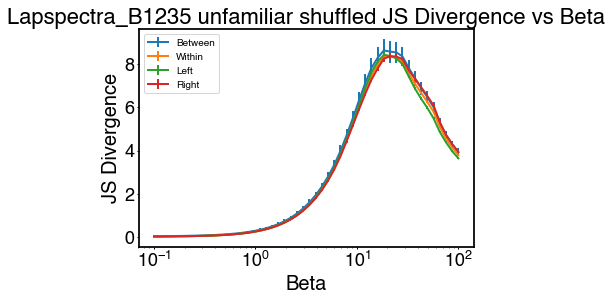

In [30]:
for indf, pair in enumerate(tqdm(file_pairs)):
    lap_file, m_file = pair
    
    params = get_lapfile_params(lap_file)
    with open(lap_file, 'rb') as f:
        lapspectra = pickle.load(f)
    with open(m_file, 'rb') as f:
        Mspectra = pickle.load(f)
    btwn_means = np.zeros(len(betas))
    btwn_stds = np.zeros(len(betas))
    wthn_means = np.zeros(len(betas))
    wthn_stds = np.zeros(len(betas))
    wthn1_means = np.zeros(len(betas))
    wthn1_stds = np.zeros(len(betas))
    wthn2_means = np.zeros(len(betas))
    wthn2_stds = np.zeros(len(betas))

    for ind, beta in enumerate(tqdm(betas)):
        mat = compute_JS_div_mtx(lapspectra, Mspectra, beta)
        (btwn, wthn1, wthn2) = compute_withins_vs_between(mat, ntrials, nstim, diag=0)
    #     btwn = np.sqrt(btwn)
    #     wthn1 = np.sqrt(wthn1)
    #     wthn2 = np.sqrt(wthn2)
        wthn = np.concatenate((wthn1, wthn2))
        btwn_means[ind] = np.mean(btwn)
        btwn_stds[ind] = np.std(btwn) / np.sqrt(len(btwn))
        wthn_means[ind] = np.mean(wthn)
        wthn_stds[ind] = np.std(wthn) / np.sqrt(len(wthn))
        wthn1_means[ind] = np.mean(wthn1)
        wthn1_stds[ind] = np.std(wthn1) / np.sqrt(len(wthn1))
        wthn2_means[ind] = np.mean(wthn2)
        wthn2_stds[ind] = np.std(wthn2) / np.sqrt(len(wthn2))
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
    plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS Divergence vs Beta'.format(params['bird'], params['fam'], params['shuf']))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.legend(['Between', 'Within', 'Left', 'Right'])
    plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(params['bird'], params['fam'], params['shuf'])))

/home/AD/btheilma/anaconda3/envs/neuraltda-4/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


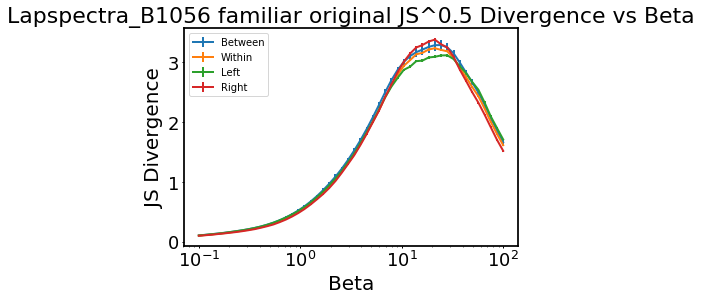

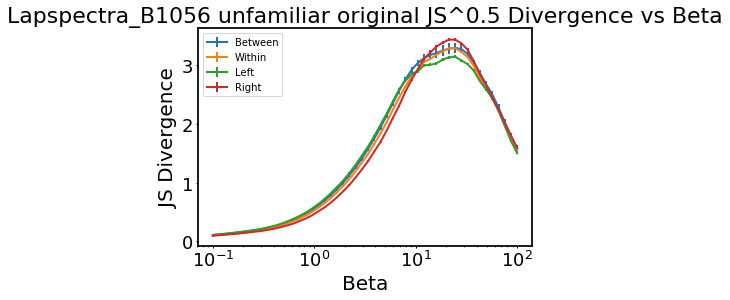

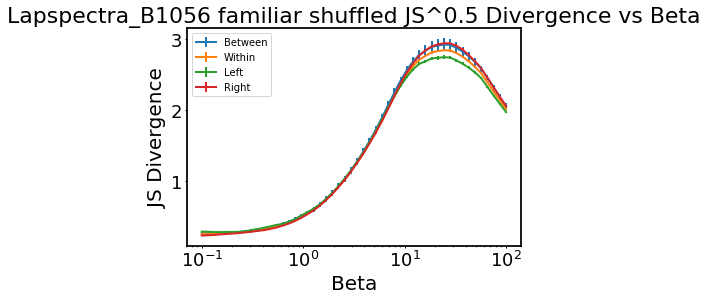

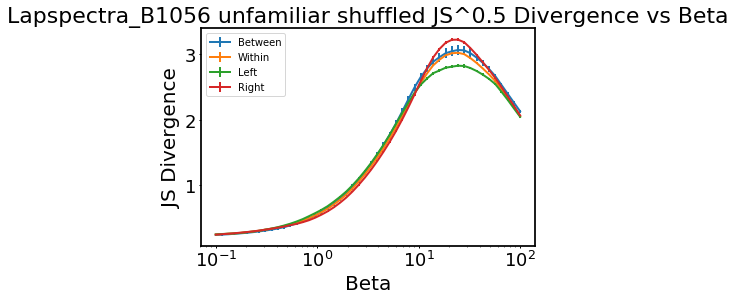

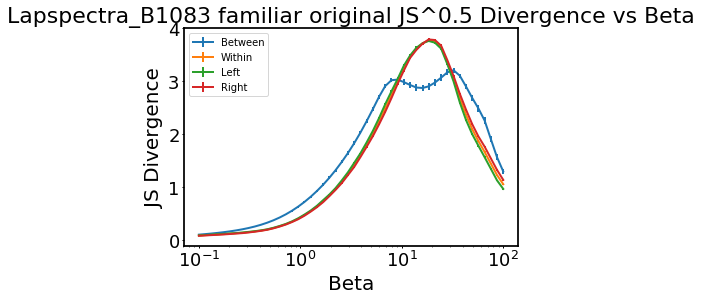

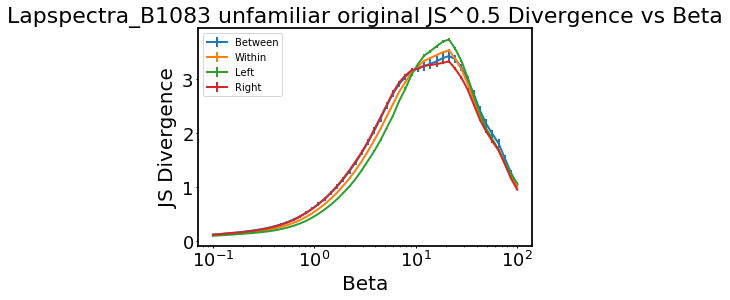

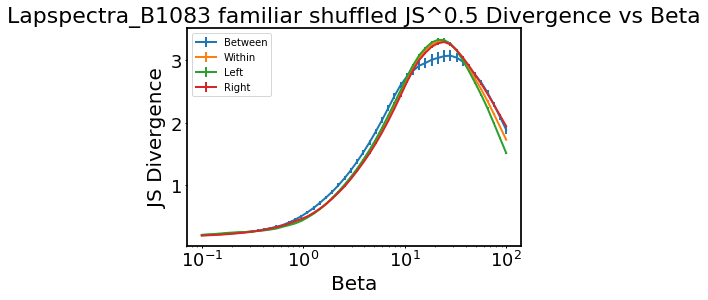

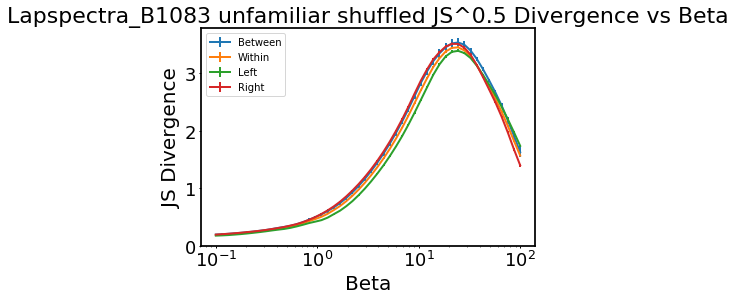

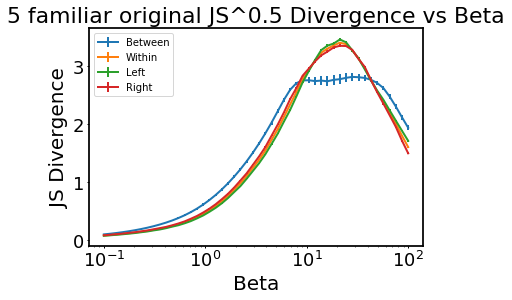

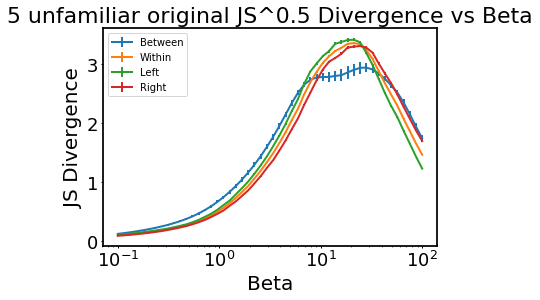

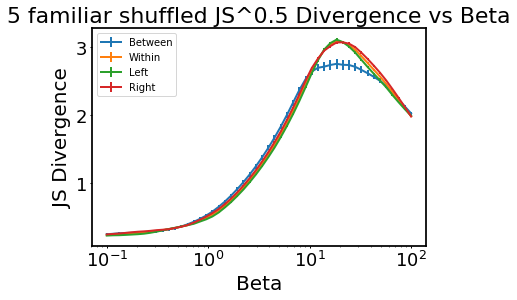

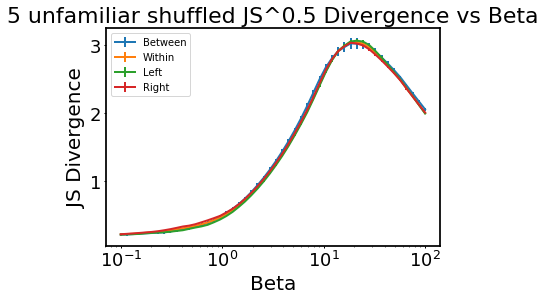

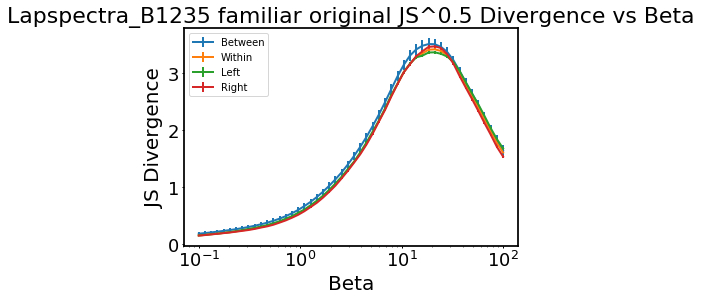

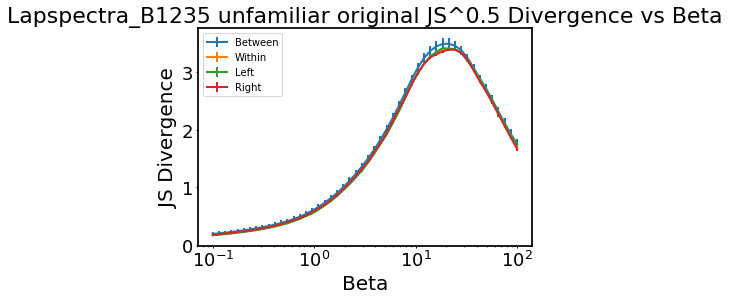

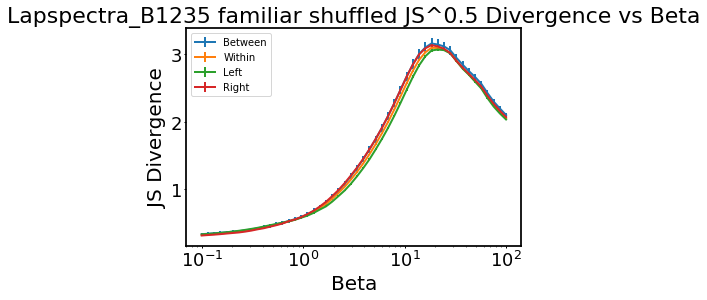

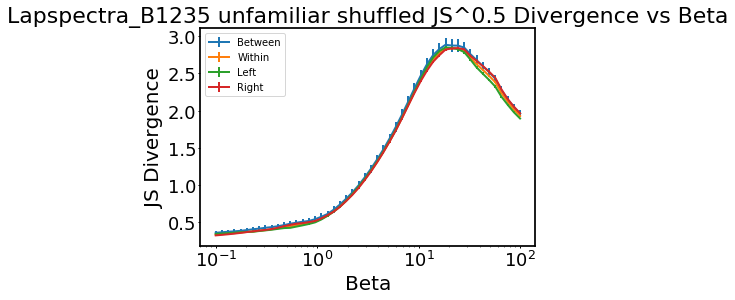

In [17]:
# Sqrt JS
betas = np.logspace(-1, 2, 50)
divs = {}
for indf, pair in enumerate(tqdm(file_pairs)):
    lap_file, m_file = pair
    
    params = get_lapfile_params(lap_file)
    with open(lap_file, 'rb') as f:
        lapspectra = pickle.load(f)
    with open(m_file, 'rb') as f:
        Mspectra = pickle.load(f)
    btwn_means = np.zeros(len(betas))
    btwn_stds = np.zeros(len(betas))
    wthn_means = np.zeros(len(betas))
    wthn_stds = np.zeros(len(betas))
    wthn1_means = np.zeros(len(betas))
    wthn1_stds = np.zeros(len(betas))
    wthn2_means = np.zeros(len(betas))
    wthn2_stds = np.zeros(len(betas))

    for ind, beta in enumerate(tqdm(betas)):
        mat = np.sqrt(compute_JS_div_mtx(lapspectra, Mspectra, beta))
        (btwn, wthn1, wthn2) = compute_withins_vs_between(mat, ntrials, nstim, diag=0)
    #     btwn = np.sqrt(btwn)
    #     wthn1 = np.sqrt(wthn1)
    #     wthn2 = np.sqrt(wthn2)
        wthn = np.concatenate((wthn1, wthn2))
        btwn_means[ind] = np.nanmean(btwn)
        btwn_stds[ind] = np.nanstd(btwn) / np.sqrt(len(btwn))
        wthn_means[ind] = np.nanmean(wthn)
        wthn_stds[ind] = np.nanstd(wthn) / np.sqrt(len(wthn))
        wthn1_means[ind] = np.nanmean(wthn1)
        wthn1_stds[ind] = np.nanstd(wthn1) / np.sqrt(len(wthn1))
        wthn2_means[ind] = np.nanmean(wthn2)
        wthn2_stds[ind] = np.nanstd(wthn2) / np.sqrt(len(wthn2))
        
    divs[(params['bird'], params['fam'], params['shuf'])] =  (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds)
    
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
    plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(params['bird'], params['fam'], params['shuf']))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.legend(['Between', 'Within', 'Left', 'Right'])
    plt.savefig(os.path.join(figsavepth, '{}-{}-{}-SqrtJSDivVsBeta.pdf'.format(params['bird'], params['fam'], params['shuf'])))

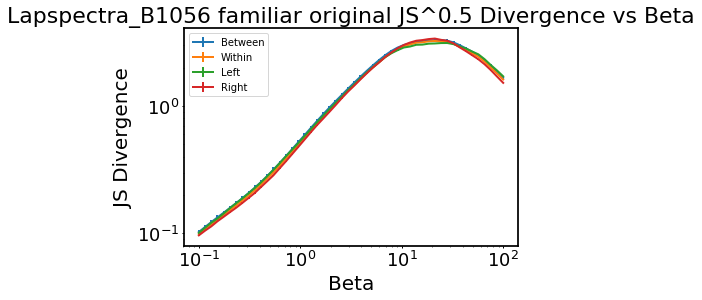

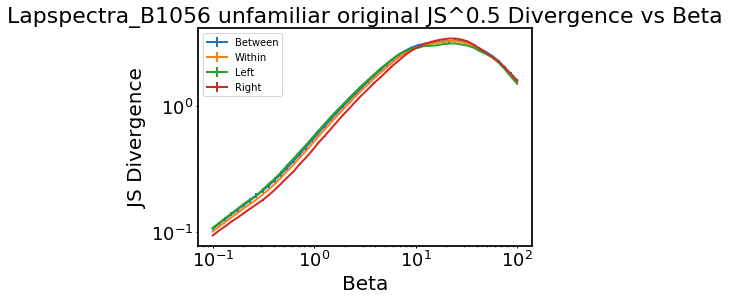

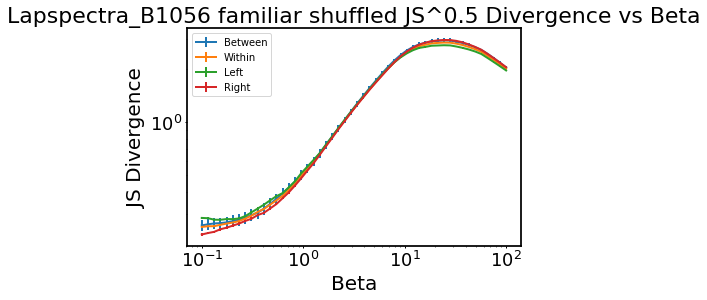

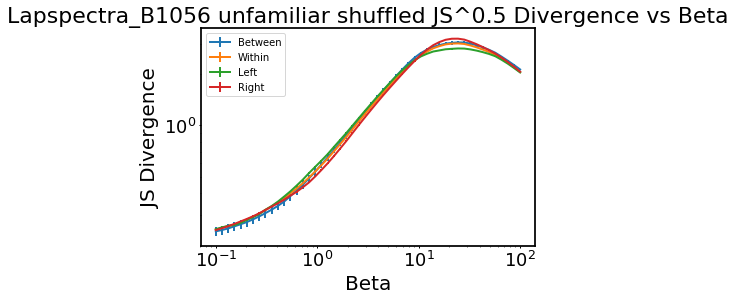

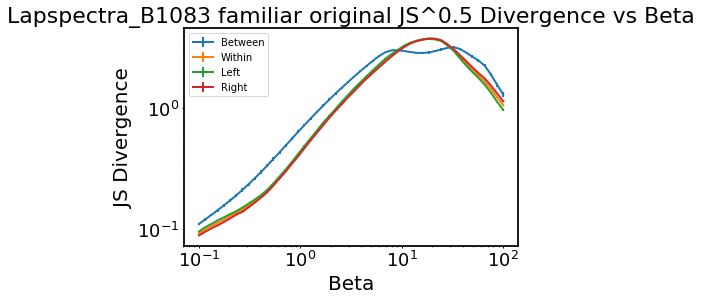

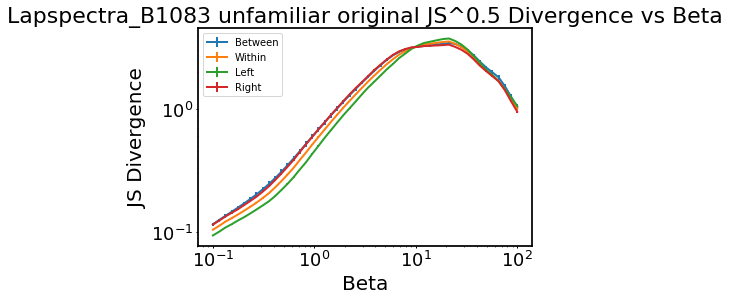

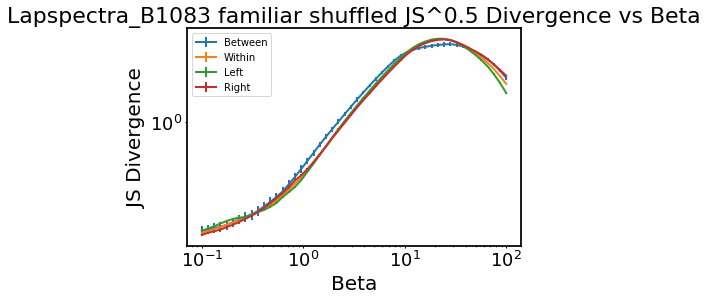

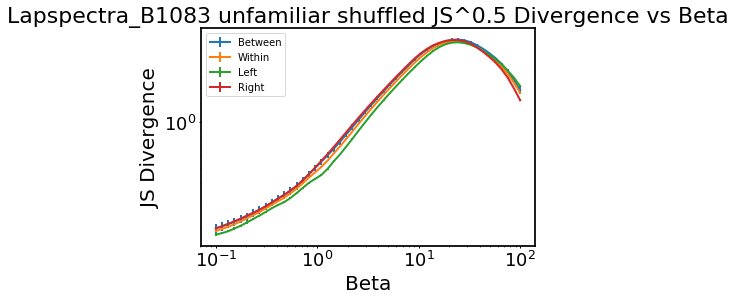

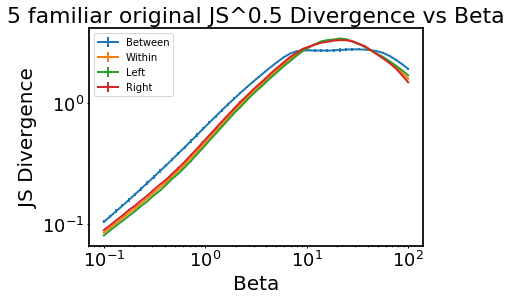

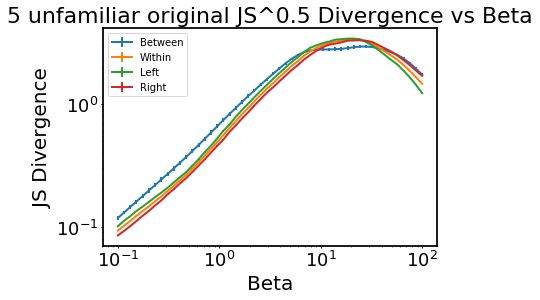

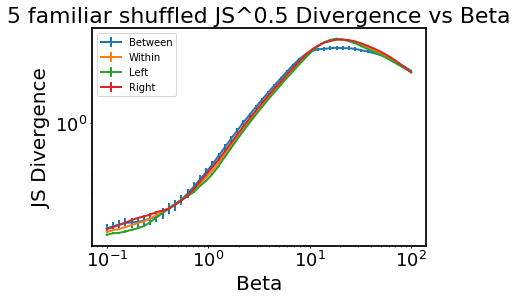

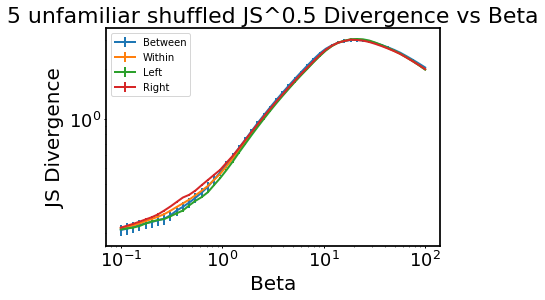

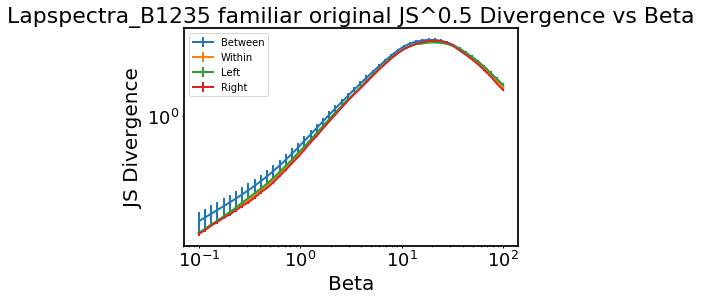

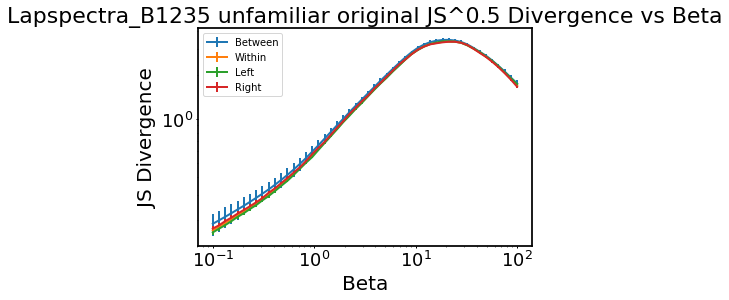

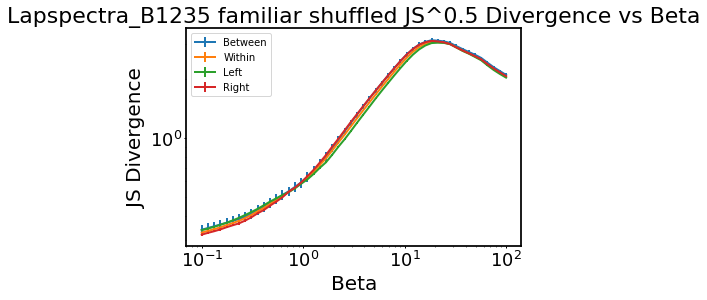

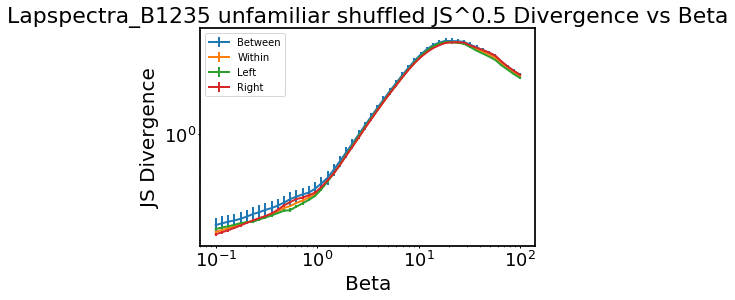

In [19]:
for k in divs.keys():
    (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds) = divs[k]
    bird = k[0]
    fam = k[1]
    shuf = k[2]
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
    plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(bird, fam, shuf))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.legend(['Between', 'Within', 'Left', 'Right'])
    #plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(bird, fam, shuf))

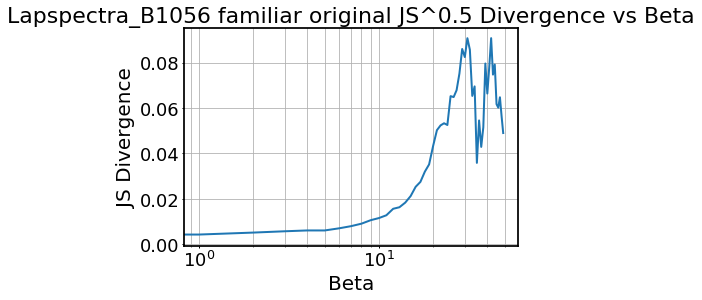

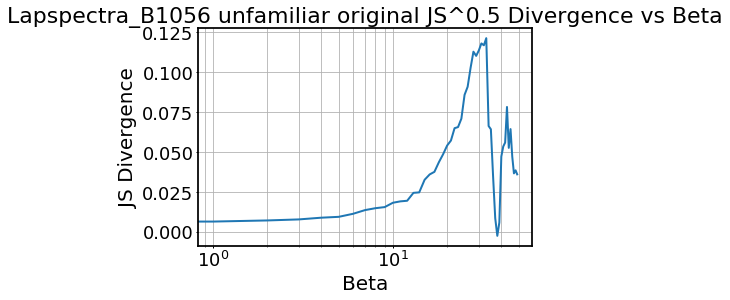

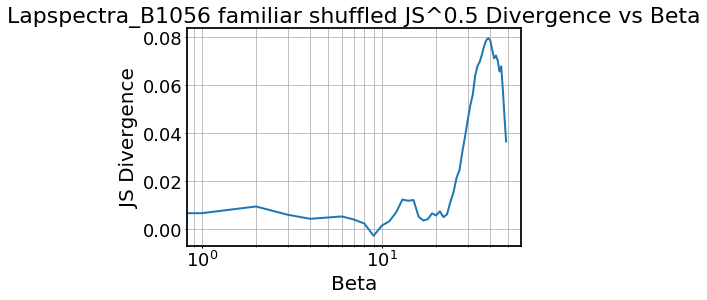

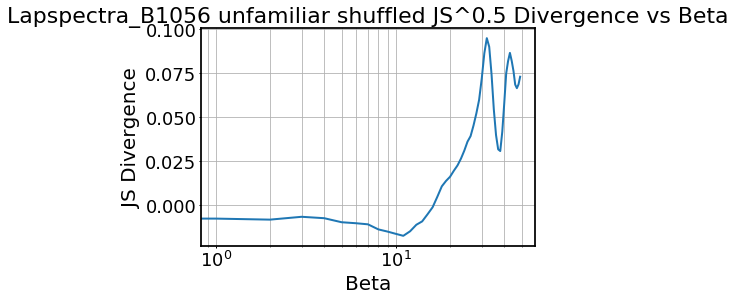

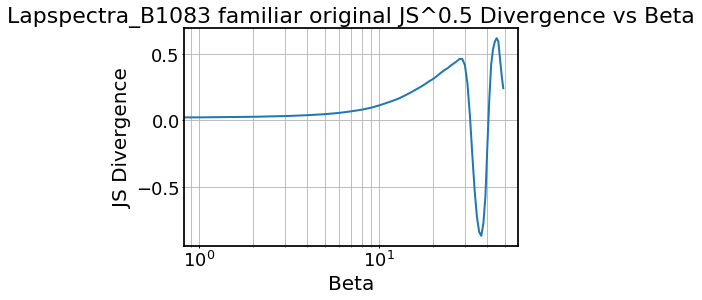

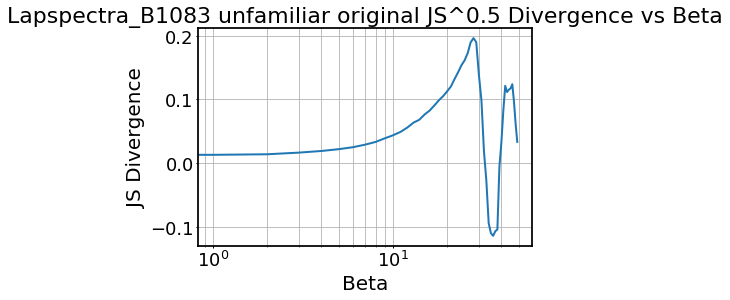

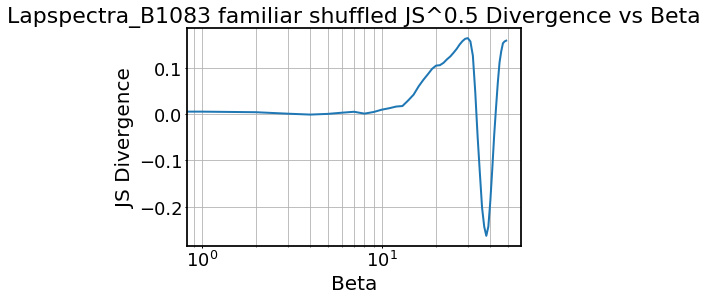

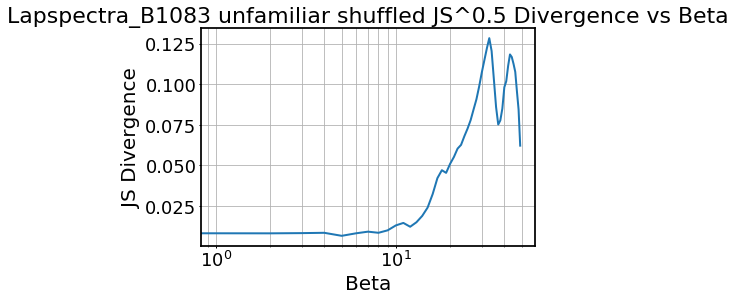

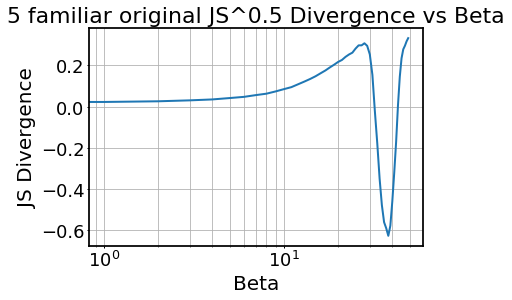

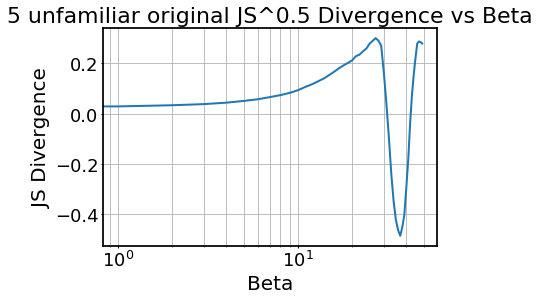

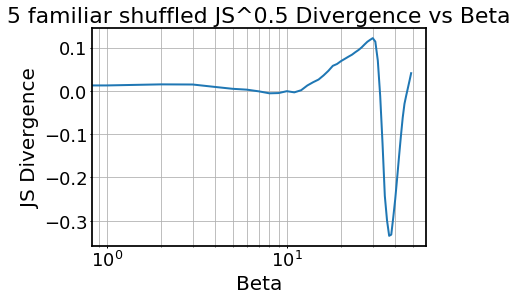

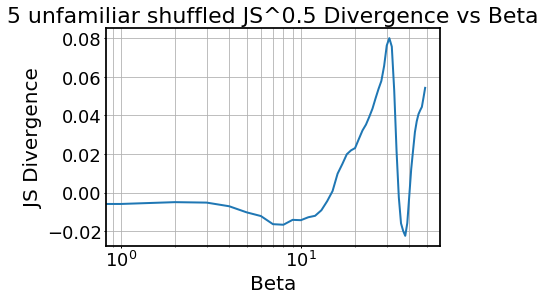

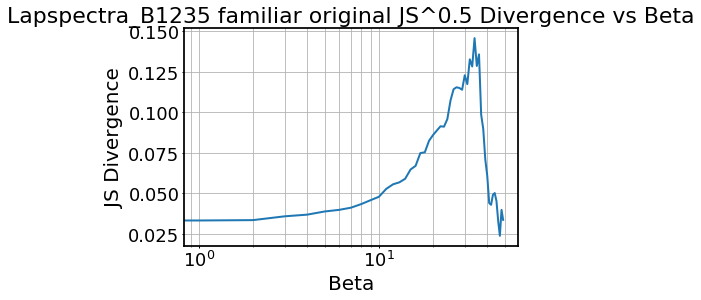

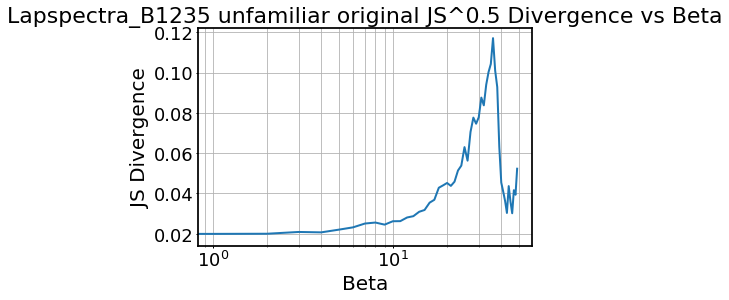

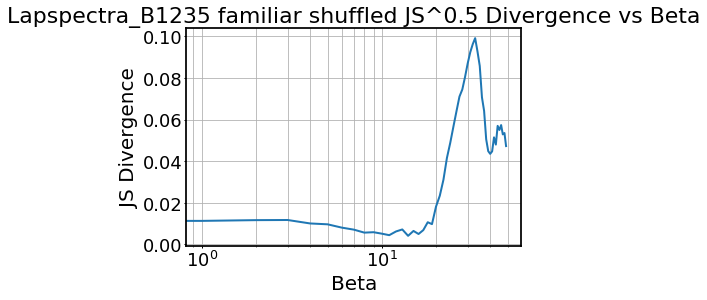

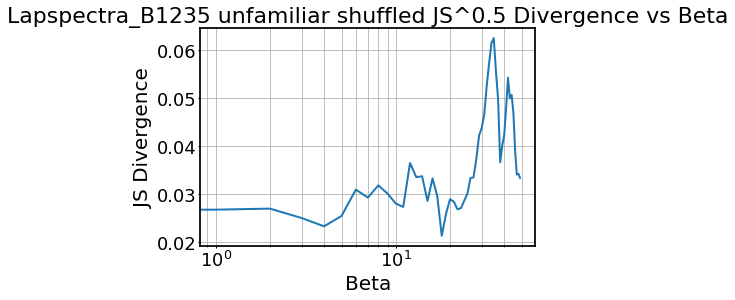

In [21]:
for k in divs.keys():
    (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds) = divs[k]
    bird = k[0]
    fam = k[1]
    shuf = k[2]
    plt.figure()
    plt.semilogx(btwn_means - wthn_means)
    plt.grid(which='both')
#     ax = plt.subplot(111)
#     ax.set_xscale("log", nonposx='clip')
#     #ax.set_yscale("log", nonposy='clip')
#     plt.errorbar(betas, btwn_means, yerr=btwn_stds)
#     plt.errorbar(betas, wthn_means, yerr=wthn_stds)
#     plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
#     plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
    plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(bird, fam, shuf))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
#     plt.legend(['Between', 'Within', 'Left', 'Right'])
    #plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(bird, fam, shuf))

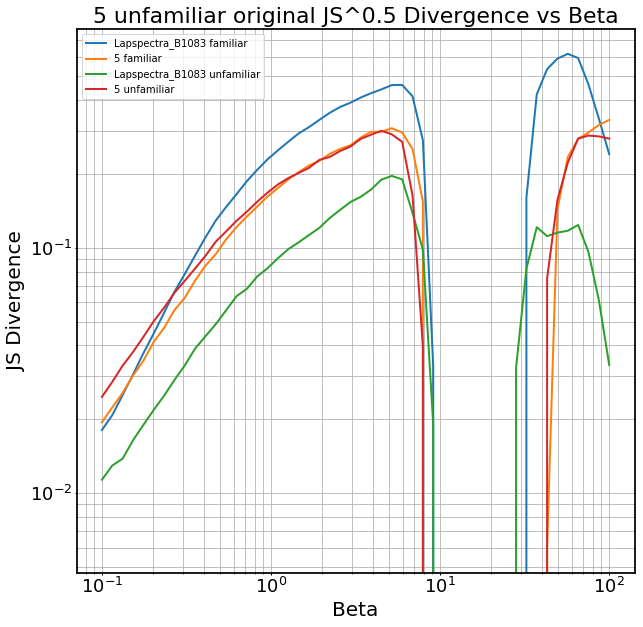

In [32]:
 plt.figure(figsize=(10, 10))
for k in [('Lapspectra_B1083', 'familiar', 'original'), ('5', 'familiar', 'original'),
          ('Lapspectra_B1083', 'unfamiliar', 'original'), ('5', 'unfamiliar', 'original')]:
    (btwn_means, btwn_stds, wthn_means, wthn_stds, wthn1_means, wthn1_stds, wthn2_means, wthn2_stds) = divs[k]
    bird = k[0]
    fam = k[1]
    shuf = k[2]
   
    plt.loglog(betas, btwn_means - wthn_means, label=bird + ' ' + fam)
plt.grid(which='both')
#     ax = plt.subplot(111)
#     ax.set_xscale("log", nonposx='clip')
#     #ax.set_yscale("log", nonposy='clip')
#     plt.errorbar(betas, btwn_means, yerr=btwn_stds)
#     plt.errorbar(betas, wthn_means, yerr=wthn_stds)
#     plt.errorbar(betas, wthn1_means, yerr=wthn1_stds)
#     plt.errorbar(betas, wthn2_means, yerr=wthn2_stds)
plt.title('{} {} {} JS^0.5 Divergence vs Beta'.format(bird, fam, shuf))
plt.xlabel('Beta')
plt.ylabel('JS Divergence')
plt.legend()
#plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta.pdf'.format(bird, fam, shuf))

Text(0,0.5,'JS Divergence')

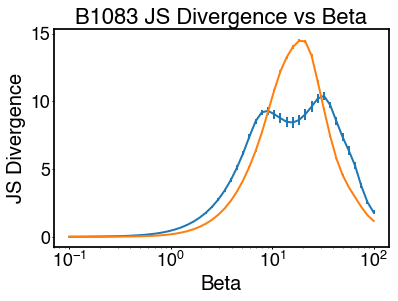

In [6]:
ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
plt.errorbar(betas, btwn_means, yerr=btwn_stds)
plt.errorbar(betas, wthn_means, yerr=wthn_stds)
plt.title('B1083 JS Divergence vs Beta')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')

In [4]:

beta = 1
jsdivs = {}
for indf, pair in enumerate(tqdm(file_pairs)):
    lap_file, m_file = pair
    
    params = get_lapfile_params(lap_file)
    with open(lap_file, 'rb') as f:
        lapspectra = pickle.load(f)
    with open(m_file, 'rb') as f:
        Mspectra = pickle.load(f)

    mat = compute_JS_div_mtx(lapspectra, Mspectra, beta)
    jsdiv = (mat + mat.T)
    jsdiv[np.abs(jsdiv) < 1e-14] = 0
    jsdivs[(params['bird'], params['fam'], params['shuf'])] = jsdiv
    

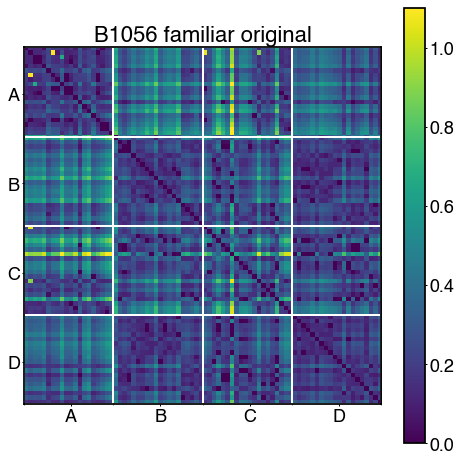

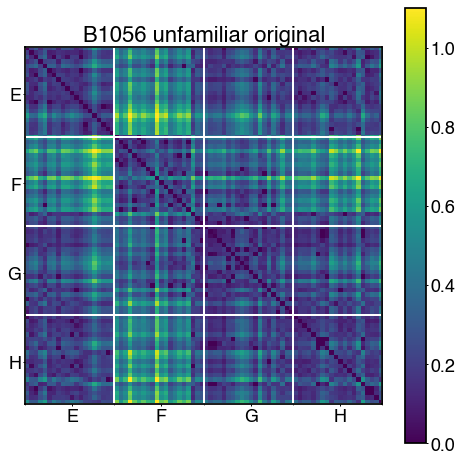

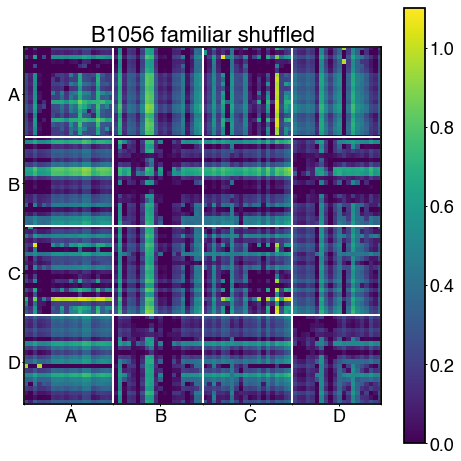

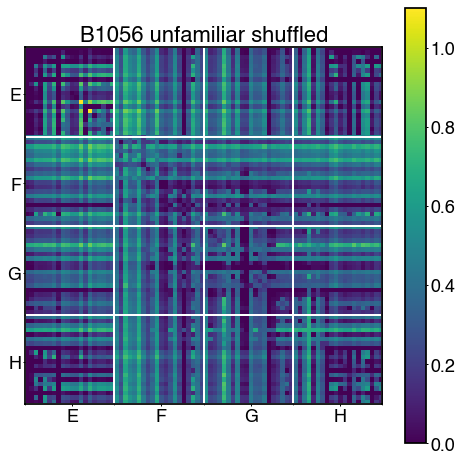

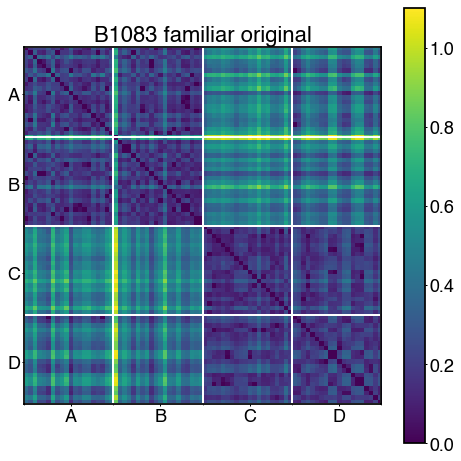

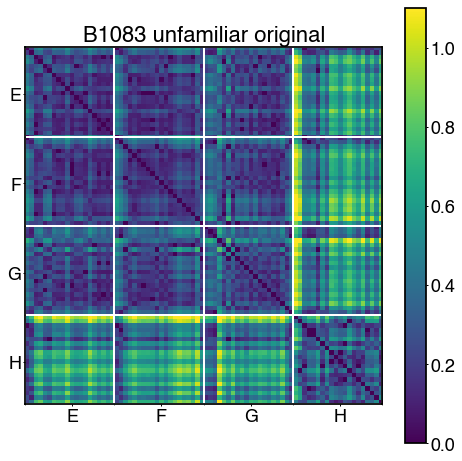

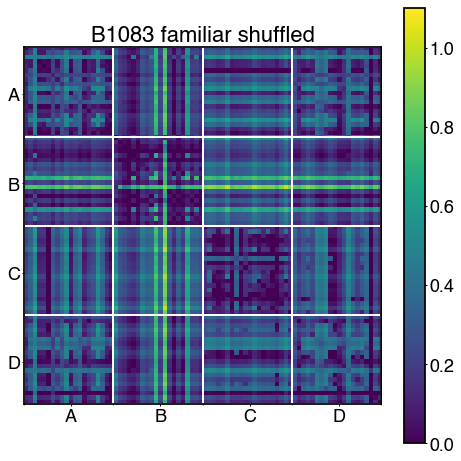

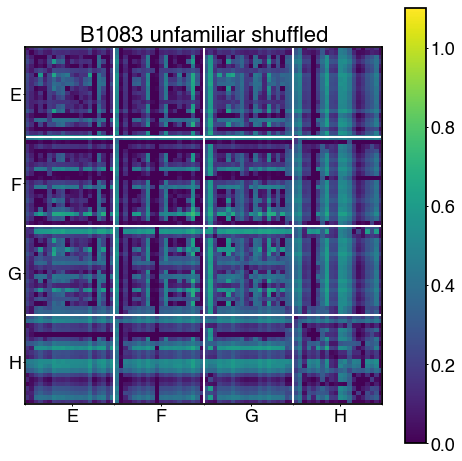

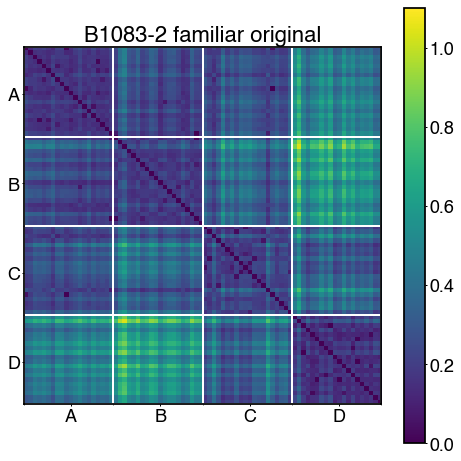

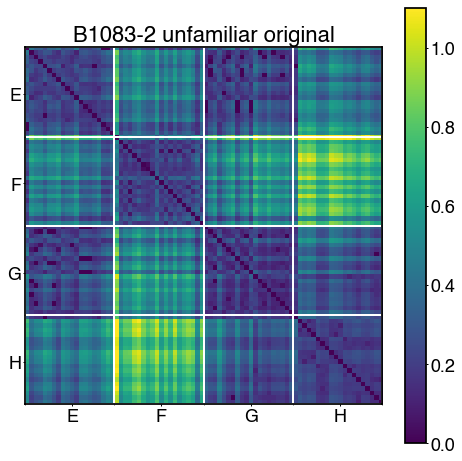

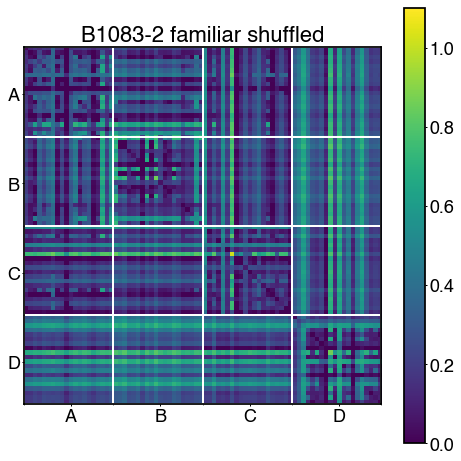

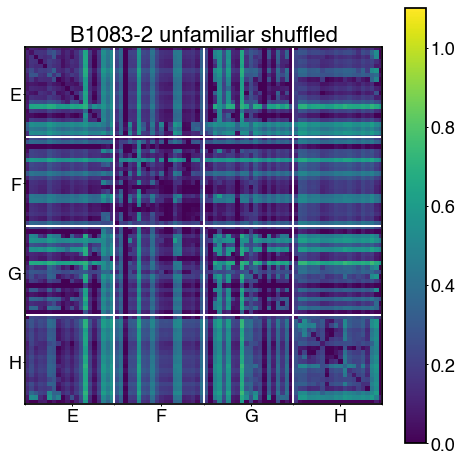

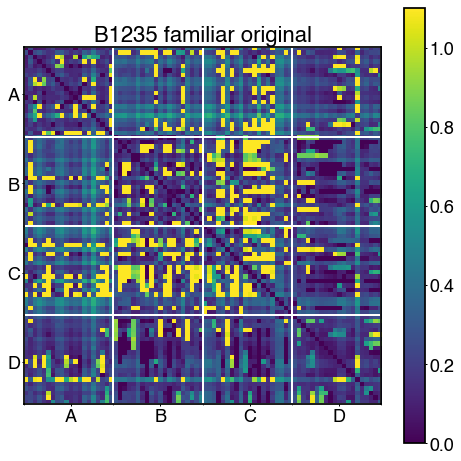

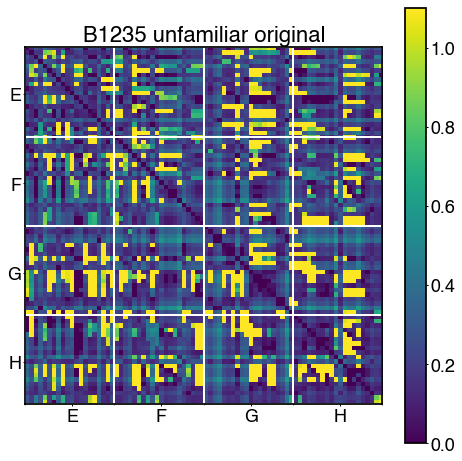

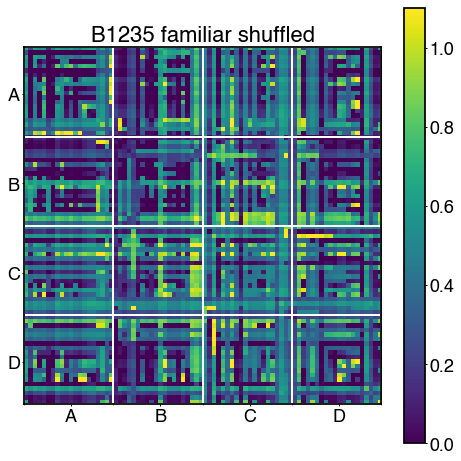

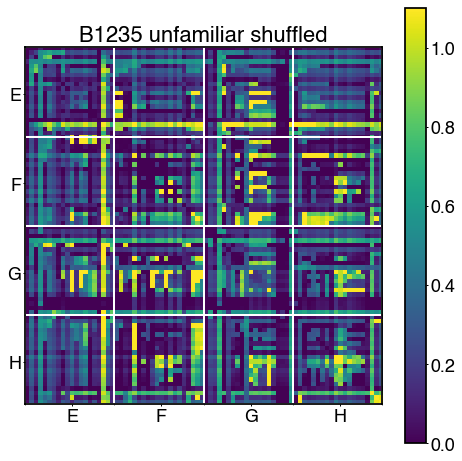

In [5]:
dat_keys = [('Lapspectra_B1083', 'familiar', 'original'), ('Lapspectra_B1083', 'familiar', 'shuffled'),
            ('Lapspectra_B1083', 'unfamiliar', 'original'), ('Lapspectra_B1083', 'unfamiliar', 'shuffled'),
            ('5', 'familiar', 'original'), ('5', 'familiar', 'shuffled'),
            ('5', 'unfamiliar', 'original'), ('5', 'unfamiliar', 'shuffled')]

birdids = {'5': 'B1083-2', 'Lapspectra_B1083': 'B1083', 'Lapspectra_B1235': 'B1235', 'Lapspectra_B1056': 'B1056', 'Lapspectra_B1075': 'B1075'}

ticklabels = [['A', 'B', 'C', 'D'], ['E', 'F', 'G', 'H']]
for k in jsdivs.keys():
    
    plt.figure(figsize=(8,8))
    ntrials = 20
    nstim = 4
    b = birdids[k[0]]
    ax = plt.gca()
    dsym = jsdivs[k]
    plt.imshow(dsym,  vmin = 0, vmax=1.1, aspect='equal')
#     plt.xticks(np.arange(0,ntrials*nstim, ntrials))
#     plt.yticks(np.arange(0,ntrials*nstim, ntrials))
    ax.set_yticks(np.arange(-0.5, ntrials*nstim, ntrials), minor=True)
    ax.set_xticks(np.arange(-0.5, ntrials*nstim, ntrials), minor=True)
    ax.set_xticks(np.arange(ntrials/2, nstim*ntrials, ntrials))
    ax.set_yticks(np.arange(ntrials/2, nstim*ntrials, ntrials))
    if 'unfamiliar' in k[1]:
        tl = ticklabels[1]
    else:
        tl = ticklabels[0]
    ax.set_xticklabels(tl)
    ax.set_yticklabels(tl)
#     ax.set_xlim([-0.5, 39.5])
#     ax.set_ylim([39.5, -0.5])
    
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    plt.colorbar()
    plt.title('{} {} {}'.format(b, k[1], k[2]))
    plt.savefig(os.path.join(figsavepth, '{}_{}_{}.pdf'.format(b, k[1], k[2])))
    with open('/home/brad/tmpdata/{}_{}_{}.pkl'.format(b, k[1], k[2]), 'wb') as f:
        pickle.dump(dsym, f)

In [23]:
jsdivs[dat_keys[-1]][0:3, :]

array([[-0.14959153,  0.10859113,  0.09116513,  0.07719951,  0.07217006,
         0.1549898 ,  0.10016287,  0.09194937,  0.05036711,  0.05900887,
         0.10000806,  0.06108391,  0.07591287,  0.09550287,  0.02364214,
         0.03982179,  0.04007038,  0.36491337,  0.3258431 ,  0.15819738,
         0.09728723,  0.29936107, -0.165456  ,  0.04025283,  0.10193677,
         0.49874189,  0.11206546,  0.10028351,  0.30833972,  0.11107943,
        -0.01346866,  0.00197579,  0.00417459,  0.09117661,  0.06720388,
         0.00899067,  0.01644937,  0.0801973 , -0.059819  ,  0.2252319 ,
         0.14020409, -0.02104262,  0.07956804,  0.07920276,  0.03092646,
         0.0902782 ,  0.07321167, -0.02111901,  0.05716854,  0.10826951,
         0.19002476,  0.15262406,  0.05677492, -0.00134362,  0.08592207,
         0.01857275,  0.08189287,  0.06444275,  0.0740536 , -0.00714662,
         0.00173475,  0.21929058,  0.20007304,  0.15465597,  0.16514095,
         0.14910912,  0.08392813,  0.09508618,  0.1

In [17]:
dat_keys[0]

('Lapspectra_B1083', 'familiar', 'original')